In [ ]:
#           "role": "system", 
#           "content": "Translate the provided Moroccan Darija language verbs into English using word-by-word translation." + 
#           "Please fulfill the following conditions when translating."+
#           "The translation must contain only the lemma of the translated verb. It should not contain 'to' for example"+

check previous work with stratified 

should the transliteration be any more checked within itself between the two results?

there must be a clearance of all useless work.

In [2]:
from openai import OpenAI
import pandas as pd
df = pd.read_csv('verbs.csv')
df = df.head(100)
client = OpenAI()

def p4_translate_(verb):
    completion = client.chat.completions.create(
        model="gpt-3.5-turbo",
messages = [
            {"role": "system", "content": 
                "ترجم الفعل المعطي بالدارجة المغربية لفعل انجليزي مجرد المصدر.\n" +
                "الترجمة خص يكون فيها غير جذر الفعل المترجم بلا تفسيرات."
             },
            {"role": "user", "content": f"{verb}"},
],
        temperature=0
    )
    return completion.choices[0].message.content

def eng_p4_translate_(verb):
    completion = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": 
                "Translate the provided Moroccan Darija dialect verb into a bare-infinitive English verb.\n" + 
                "The translation must contain only the lemma of the translated verb with no explanations."},
            {"role": "user", "content": f"{verb}"},
        ],
        temperature=0
    )
    return completion.choices[0].message.content





In [3]:
dataset = df.copy()
columns_to_delete = ['n1','n2', 'n3', 'n4', 'n5', 'n6']
dataset.drop(columns=columns_to_delete, inplace=True)


dataset['p4_transl'] = dataset['darija_ar'].apply(p4_translate_)
dataset['eng_p4_transl'] = dataset['darija_ar'].apply(eng_p4_translate_)

In [4]:
import matplotlib.pyplot as plt
from nltk.corpus import wordnet as wn


eng = dataset['eng']
p4_transl = dataset['p4_transl']
eng_p4_transl = dataset['eng_p4_transl']

p4_transl = [verb.replace(" ", "_") for verb in p4_transl]
eng_p4_transl = [verb.replace(" ", "_") for verb in eng_p4_transl]

eng = [verb.replace(" ", "_") for verb in eng]


def max_path_similarity(word1, word2):
    """Calculate the maximum path similarity between two words."""

    synsets1 = wn.synsets(word1, pos=wn.VERB)
    synsets2 = wn.synsets(word2, pos=wn.VERB)
    max_score = 0
    for syn1 in synsets1:
        for syn2 in synsets2:
            score = syn1.path_similarity(syn2)
            if score and score > max_score:
                max_score = score
    return max_score

def evaluate_pairs(transl,threshold=0.5):
    """Evaluating each pair using WordNet path similarity and a threshold."""
    results = []
    for i in range(len(transl)):
        word1, word2 = transl[i], eng[i]
        similarity = max_path_similarity(word1, word2)
        results.append((word1, word2, similarity, similarity >= threshold))
    return results

results_p4 = evaluate_pairs(p4_transl)
results_eng_p4 = evaluate_pairs(eng_p4_transl)

dataset['similarity_p4'] = [item[2] for item in results_p4]
dataset['similarity_eng_p4'] = [item[2] for item in results_eng_p4]

p4_s = dataset['similarity_p4'] 
ep4_s = dataset['similarity_eng_p4']

p4= dataset['similarity_p4'].mean()
ep4= dataset['similarity_eng_p4'].mean()

print(f'Mean value of similarities in the fourth darija prompt is: {p4}')
print(f'Mean value of similarities in the fourth english prompt is: {ep4}')
dataset.describe()



Mean value of similarities in the fourth darija prompt is: 0.7028333333333333
Mean value of similarities in the fourth english prompt is: 0.7200952380952381


,similarity_p4,similarity_eng_p4
count,100.000000,100.000000
mean,0.702833,0.720095
std,0.398644,0.388145
min,0.000000,0.000000
25%,0.250000,0.333333
50%,1.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


In [5]:
from scipy.stats import f_oneway

f_stat, p_value = f_oneway(p4_s, ep4_s)


print(f"F-statistic: {f_stat}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("Significant difference between the fourth prompts written in English and Darija")
else:
    print("No significant difference between the frouth prompts written in English and Darija")

F-statistic: 0.09625268014564181
P-value: 0.7567000826358858
No significant difference between the frouth prompts written in English and Darija


In [6]:
import plotly.express as px

dataset['triple_verbs'] = dataset['eng'] + ', ' + dataset['p4_transl'] + ', ' + dataset['eng_p4_transl']

# Create the scatter plot with custom hover data
fig = px.scatter(
    dataset,
    x='similarity_p4',
    y='similarity_eng_p4',
    hover_name='triple_verbs',
    hover_data={
        'similarity_p4': True,
        'similarity_eng_p4': True,
    }
)

# Customize the marker properties
fig.update_traces(
    marker=dict(size=10, opacity=0.2),
    text=dataset['eng'],
    textposition='top center'
)

# Show the plot
fig.show()

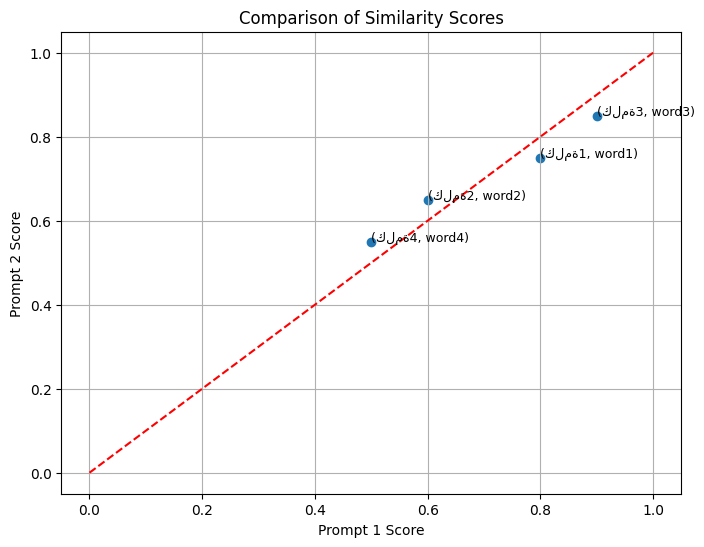

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# Example data
data = {
    'Arabic Word': ['كلمة1', 'كلمة2', 'كلمة3', 'كلمة4'],
    'English Word': ['word1', 'word2', 'word3', 'word4'],
    'Prompt 1 Score': [0.8, 0.6, 0.9, 0.5],
    'Prompt 2 Score': [0.75, 0.65, 0.85, 0.55]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Plotting the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df['Prompt 1 Score'], df['Prompt 2 Score'])

# Adding labels for each point
for i in range(len(df)):
    plt.text(df['Prompt 1 Score'][i], df['Prompt 2 Score'][i], 
             f"({df['Arabic Word'][i]}, {df['English Word'][i]})", fontsize=9)

# Adding a diagonal line to show perfect correlation
plt.plot([0, 1], [0, 1], color='red', linestyle='--')

plt.title('Comparison of Similarity Scores')
plt.xlabel('Prompt 1 Score')
plt.ylabel('Prompt 2 Score')
plt.grid(True)
plt.show()


#### Pearson Correlation:

Type: Measures linear relationship.

Values: Ranges from -1 to 1.

1 indicates a perfect positive linear relationship.

-1 indicates a perfect negative linear relationship.

0 indicates no linear relationship.

Assumptions: Assumes both variables are normally distributed and have a linear relationship.
Sensitivity:  # Sensitive to outliers.

#### Spearman Correlation:


Type: Measures monotonic relationship (whether variables tend to move in the same or opposite directions).

Values: Also ranges from -1 to 1.

1 indicates a perfect positive monotonic relationship.

-1 indicates a perfect negative monotonic relationship.

0 indicates no monotonic relationship.

Assumptions: Non-parametric (does not assume any specific distribution); based on rank order.

Sensitivity: Less sensitive to outliers compared to Pearson.


In [8]:
from scipy.stats import spearmanr, pearsonr


spearman_corr, _ = spearmanr(dataset['similarity_p4'], dataset['similarity_eng_p4'])
print(f'Spearman correlation: {spearman_corr}')

pearson_corr, _ = pearsonr(dataset['similarity_p4'], dataset['similarity_eng_p4'])
print(f'Pearson correlation: {pearson_corr}')


Spearman correlation: 0.6436228935054733
Pearson correlation: 0.6322268797813114


In [9]:
dataset.columns 

Index(['darija_ar', 'eng', 'p4_transl', 'eng_p4_transl', 'similarity_p4',
       'similarity_eng_p4', 'triple_verbs'],
      dtype='object')

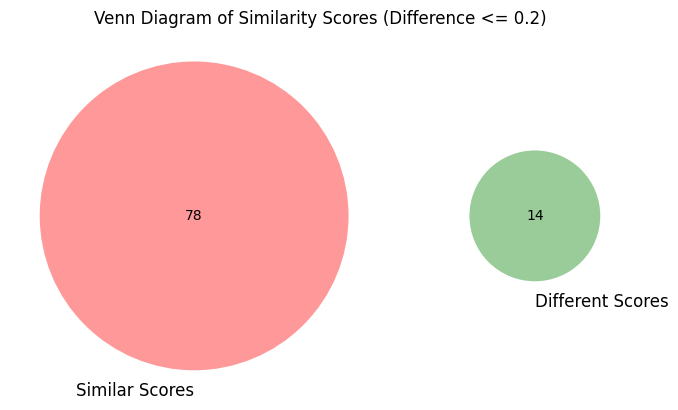

In [10]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

threshold = 0.2

# Determine sets based on the similarity difference threshold
set_prompt1 = set(dataset[(abs(dataset['similarity_p4'] - dataset['similarity_eng_p4']) <= threshold)]['eng'])
set_prompt2 = set_prompt1  # Since we're comparing the same pairs

# Plot Venn diagram
plt.figure(figsize=(8, 6))
venn2([set_prompt1, set(dataset['eng']) - set_prompt1], ('Similar Scores', 'Different Scores'))
plt.title('Venn Diagram of Similarity Scores (Difference <= 0.2)')
plt.show()


Box plot

In [31]:
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Box(y=dataset['similarity_p4'], name='similarity_p4'))
fig.add_trace(go.Box(y=dataset['similarity_eng_p4'], name='similarity_eng_p4'))

# Update layout
fig.update_layout(
    title='Box Plot of Similarity Scores for Two Prompts',
    yaxis_title='Similarity Score',
    xaxis_title='Prompt',
    boxmode='group'  # group the box plots together
)

# Show plot
fig.show()


histogram    comparison


In [36]:
#    x=dataset['similarity_p4'],
#    name='',  # name used in legend and hover labels
#    x=dataset['similarity_eng_p4'],
#    name='English Prompt',


fig = go.Figure()

# Add histogram for Prompt 1
fig.add_trace(go.Histogram(
    x=dataset['similarity_p4'],
    name='Darija Prompt',
    opacity=0.75,
    marker=dict(color='blue')
))

# Add histogram for Prompt 2
fig.add_trace(go.Histogram(
    x=dataset['similarity_eng_p4'],
    name='English Prompt',
    opacity=0.75,
    marker=dict(color='red')
))

# Update layout for better visualization
fig.update_layout(
    title='Histogram Comparison of Similarity Scores',
    xaxis_title='Similarity Percentage',
    yaxis_title='Count',
    barmode='overlay',
    bargap=0.1,
    bargroupgap=0.1
)

# Show the plot
fig.show()



In [39]:
import plotly.graph_objects as go


fig = go.Figure()
fig.add_trace(go.Histogram(histfunc="count", y=dataset['similarity_p4'], x=dataset['similarity_p4'], name="count"))
fig.add_trace(go.Histogram(histfunc="count", y=dataset['similarity_eng_p4'], x=dataset['similarity_eng_p4'], name="sum"))

fig.show()


In [40]:
import plotly.graph_objects as go

import numpy as np

x0 = np.random.randn(2000)
x1 = np.random.randn(2000) + 1

fig = go.Figure()
fig.add_trace(go.Histogram(x=x0))
fig.add_trace(go.Histogram(x=x1))

# The two histograms are drawn on top of another
fig.update_layout(barmode='stack')
fig.show()


In [41]:
import plotly.graph_objects as go

import numpy as np

x0 = np.random.randn(500)
# Add 1 to shift the mean of the Gaussian distribution
x1 = np.random.randn(500) + 1

fig = go.Figure()
fig.add_trace(go.Histogram(x=x0))
fig.add_trace(go.Histogram(x=x1))

# Overlay both histograms
fig.update_layout(barmode='overlay')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show()


In [53]:
import plotly.express as px

df = px.data.gapminder().query("country=='Canada'")
fig = px.line(df, x="year", y="lifeExp", title='Life expectancy in Canada')
fig.show()


In [54]:
import plotly.express as px

df = px.data.gapminder().query("continent=='Oceania'")
fig = px.line(df, x="year", y="lifeExp", color='country')
fig.show()

In [55]:
import plotly.express as px
df = px.data.gapminder().query("continent == 'Oceania'")
fig = px.line(df, x='year', y='lifeExp', color='country', markers=True)
fig.show()


In [60]:
dataset.columns

Index(['darija_ar', 'eng', 'p4_transl', 'eng_p4_transl', 'similarity_p4',
       'similarity_eng_p4', 'triple_verbs'],
      dtype='object')

In [63]:
import plotly.express as px

progression = pd.DataFrame()
progression['means'] = [ dataset['similarity_p4'].mean(), dataset['similarity_eng_p4'].mean()]
progression['prompts'] =  ['prompt 1', 'prompt 2']

fig = px.line(progression, x='prompts', y='means',  markers=True)
fig.show()
